## Compare Spectra for each case with the theoretical, predicted spectra

Cleaned up version of compare_spectra_theoretical focused on comparing the stochastic model forcing with the theoretical forcing predicted from the equation.


In [100]:
import tqdm
import time
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.io import loadmat
import glob
import sys


# Indicate machine
stormtrack = 1
if stormtrack == 0:
    usr = "gliu"
    datpath = "/Users/%s/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/01_Data/model_input/" % usr
    sys.path.append("/Users/%s/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/03_Scripts/stochmod/model/"% usr)
    sys.path.append("/Users/%s/Downloads/02_Research/01_Projects/01_AMV/00_Commons/03_Scripts/"% usr)
elif stormtrack == 1: # NOTE... need to edit this
    datpath = "/stormtrack/data3/glliu/01_Data/02_AMV_Project/02_stochmod/HMXL/"
    sys.path.append("/home/glliu/00_Scripts/01_Projects/00_Commons/")
    sys.path.append("/home/glliu/00_Scripts/01_Projects/01_AMV/02_stochmod/stochmod/model/")
    scrappath = "/stormtrack/data3/glliu/01_Data/02_AMV_Project/02_stochmod/Scrap/"

import scm
from amv import proc,viz
import tbx

ModuleNotFoundError: No module named 'scm'

In [101]:
# Paths, User Inputs
outpath = "/stormtrack/data3/glliu/02_Figures/20210715/"
datpath = "/stormtrack/data3/glliu/01_Data/02_AMV_Project/02_stochmod/NHFLX/"
"""
-rw-rw-r-- 1 glliu glliu 4.5G Apr 25 17:37 NHFLX_PIC_Full.npy
-rw-rw-r-- 1 glliu glliu 1.9G Feb  2 22:57 NHFLX_PIC.nc
-rw-rw-r-- 1 glliu glliu 1.8G Feb 19 01:18 NHFLX_PIC_SLAB_raw.nc
-rw-rw-r-- 1 glliu glliu 1.3G Feb 19 02:09 TS_PIC_SLAB_raw.nc
"""
#datpath = "/stormtrack/data3/glliu/01_Data/02_AMV_Project/01_hfdamping/hfdamping_PIC_SLAB/02_ENSOREM/"

"""
-rw-rw-r-- 1 glliu glliu 2.3G Nov 15  2020 ENSOREM_TS_lag1_pcs2_monwin3.npz
-rw-rw-r-- 1 glliu glliu 2.3G Mar 19 04:19 ENSOREM_NHFLX_lag1_pcs2_monwin3.npy
"""
#
ampq     = False # Set to true to amplify q' magnitude based on its underestimation
lbdvary  = True
qvary    = True    # True to vary stochastic forcing amplitude monthly
useeof   = True # Set to True to use EOF-based forcing

# Constants
underest_method = 0 # Set 0 to consider T(t) in phase, 1 to use [T(t)+T(t-1)]/2 for underestimation
runid   = "th009"   # Run id to check for
simlen  = 12*5000#None
rho     = 1026
cp0     = 3996
hmean   = 54.61088498433431 # from SLAB_PIC_hblt.npy
mons3   = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')
mldmode = "Const" # Set to "Const" to use the same constant MLD [hmean] for all months

# Load lat/lon (360)
datpath2 = "/stormtrack/data3/glliu/01_Data/02_AMV_Project/02_stochmod/Model_Data/model_input/"
mt       = loadmat("/home/glliu/01_Data/CESM1_LATLON.mat")
lat      = mt["LAT"].squeeze()#np.load(datpath2+"../lat.npy")
lon36    = mt["LON"].squeeze()#np.load(datpath2+"../lon.npy")
lon,_    = proc.lon360to180(lon36,np.ones((288,192,1)))

# Set point where analysis will occur
lonf      = -30
latf      = 50
klon,klat = proc.find_latlon(lonf,latf,lon,lat)

# Load SST, NHFLX, from CESM-SLAB

### Load SST from CESM-SLAB

In [102]:
%%time 

ds   = xr.open_dataset(datpath+"TS_PIC_SLAB_raw.nc")
dspt = ds.sel(lon=330,lat=50,method='nearest')
T    = dspt.TS.values
dspt

CPU times: user 413 ms, sys: 48.9 ms, total: 462 ms
Wall time: 459 ms


<xarray.Dataset>
Dimensions:  (time: 10812)
Coordinates:
    lev      float64 ...
    lat      float64 50.42
    lon      float64 330.0
  * time     (time) object 0101-02-01 00:00:00 ... 1002-01-01 00:00:00
Data variables:
    TS       (time) float32 282.09058 280.616 280.64438 ... 284.21448 283.3534
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             e.e11.E1850C5CN.f09_g16.001
    title:            UNSET
    logname:          adrianne
    host:             ys0222
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /glade/p/cesmdata/cseg/inputdata/atm/cam/inic/fv/cami-m...
    topography_file:  /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/USGS-gtop...

### Load NHFLX from CESM1-SLAB

In [103]:
%%time 

ds    = xr.open_dataset(datpath+"NHFLX_PIC_SLAB_raw.nc")
dspt  = ds.sel(lon=330,lat=50,method='nearest')
Q     = dspt.NHFLX.values

# Get # of Years
ntime = Q.shape[0]
nyr   = int(ntime/12)
dspt

CPU times: user 289 ms, sys: 15.3 ms, total: 304 ms
Wall time: 302 ms


<xarray.Dataset>
Dimensions:  (time: 10812)
Coordinates:
    lev      float64 ...
    lat      float64 50.42
    lon      float64 330.0
  * time     (time) object 0101-01-01 00:00:00 ... 1001-12-01 00:00:00
Data variables:
    NHFLX    (time) float32 -245.63795 -158.8689 ... -121.01072 -190.09209

### Load in data for Qnet, CESM-FULL

In [104]:
%%time 
# Load in data for Qnet, CESM-FULL
Qfull   = np.load(datpath+"NHFLX_PIC_Full.npy")

#Get Data for Point
klon360,_ = proc.find_latlon(lonf+360,latf,lon36,lat)
Qfullpt   = Qfull[:,:,klat,klon360]
Qafullpt  = Qfullpt - Qfullpt.mean(0)[None,:]

Closest lon to 330.00 was 330.00
Closest lat to 50.00 was 50.42
CPU times: user 0 ns, sys: 3.51 s, total: 3.51 s
Wall time: 3.5 s


### Calculate monthly anomalies for each CESM variable

In [105]:
%%time
# Remove monthly anomalies for each CESM variable
# Preallocate
v_in  = [T,Q,Qfullpt.flatten()]
v_a   = []
for v in v_in:
    
    v  = v.reshape(int(v.shape[0]/12),12)
    va = v - v.mean(0)[None,:]
    v_a.append(va.flatten())

Ta,Qa,Qafull = v_a

CPU times: user 1.79 ms, sys: 683 µs, total: 2.47 ms
Wall time: 1.27 ms


## Load Stochastic Model Inputs

In [106]:
# Load forcing amplitude
alpha_all = np.load(datpath2+"SLAB_PIC_NHFLXSTD_Forcing_MON.npy")
alpha_all.shape
alpha     = alpha_all[klon,klat,:]

In [107]:
# Load damping
lbd_all = np.load(datpath2+"SLAB_PIC_NHFLX_Damping_monwin3_sig005_dof894_mode4.npy")
lbd     = lbd_all[klon,klat,:]

In [108]:
# Load Mixed Layer Depth

if mldmode == "Const": # For slab runs, load a constant mixed layer depth hmean (specified upfront)
    mld     = np.ones(12)*hmean
else:
    mld_all = np.load(datpath2+"HMXL_hclim.npy")
    mld     = mld_all[klon,klat,:]
    plt.plot(mld)

# Convert Lambda from W/m2/degC to 1/sec

In [109]:
# Take average lambda and convert to 1/sec
# Calculate stochastic timeseries

avg_first     = False 
# TRUE  : average MLD (m) and lbd (W/m2/degC) first, then convert
# FALSE : convert first, then average lbd in degC/sec

lbd_mon        = lbd/(rho*cp0*mld) # Convert lbd to degC/sec
if avg_first:
    lbd_avg    = lbd.mean() / (rho*cp0*mld.mean())
else:
    lbd_avg    = lbd_mon.mean()

print("lbd_avg^-1 is %.3f months" % (1/(lbd_avg*3600*24*30))) # Express in units of months

lbd_avg^-1 is 6.661 months


# Make forcing

In [110]:
# Make or load random time series
nmons=simlen
if simlen is None:
    simlen = Qa.shape[0] # If no simulation length is specified, match PiC-SLAB simulation

forcename = "%srandts_runid%s_len%i_useeofs%i.npy" % (datpath2,runid,simlen,useeof)

if useeof:

    # Load in EOF-based forcing, get dimensions
    #f_eof   = np.load(datpath2+"flxeof_200eofs_SLAB-PIC.npy")
    #f_eof   = np.load(datpath2+"flxeof_090pct_SLAB-PIC_eofcorr1.npy")
    f_eof   = np.load(datpath2+"flxeof_090pct_SLAB-PIC_eofcorr2.npy")
    #f_eof   = np.load(datpath2+"flxeof_090pct_SLAB-PIC_eofcorr0.npy")
    pt_eof  = f_eof[klon,klat,:,:]
    N_modes = pt_eof.shape[0]
        

# Check to see if forcing should be loaded
if len(glob.glob(forcename))<1:
    print("Forcing not found")
    print("Creating and saving new forcing at %s..." % forcename)
    if useeof:

        randts = np.random.normal(0,1,(N_modes,simlen))
    else:
        randts  = np.random.normal(0,1,simlen)
    np.save(forcename,randts)
else:
    print("Old forcing file found!")
    print(forcename)
    
    randts = np.load(forcename)
        

Old forcing file found!
/stormtrack/data3/glliu/01_Data/02_AMV_Project/02_stochmod/Model_Data/model_input/randts_runidth009_len60000_useeofs1.npy


In [111]:
forcename

'/stormtrack/data3/glliu/01_Data/02_AMV_Project/02_stochmod/Model_Data/model_input/randts_runidth009_len60000_useeofs1.npy'

In [112]:
viz_check=False

if useeof:
    # Plot monthly patterns
    if viz_check:
        fig,ax = plt.subplots(1,1)
        for N in range(N_modes):
            ax.plot(pt_eof[N,:],label=N+1)
        ax.legend()
    
    # Make white noise timeseries
    nyrs        = int(simlen/12)
    pt_eof_tile = np.tile(pt_eof,nyrs)
    pt_eof_avg  = np.tile(np.abs(pt_eof).mean(1)[:,None],nmons)
    
    
    q_mon = np.nansum((pt_eof_tile*randts),0) # Monthly varying amplitude
    q_avg = np.nansum((pt_eof_avg*randts),0)#(pt_eof_avg*randts).sum(0)  # Constant Ampltiude
else:
    
    
    q_mon   = randts * np.tile(alpha,int(simlen/12)) # Monthly variying ampltiude
    q_avg   = randts * alpha.mean()                       # Constant amplitude (mean of monthly amplitudes)

In [113]:
# test = (pt_eof_tile*randts)
# test.shape


# np.var(test[:100,...].sum(0)),np.var(test[100:,...].sum(0)),np.var(Qa),np.var(Qafull)

fig,axs= plt.subplots(3,1,sharex=True,figsize=(8,6))

ax = axs[0]
ax.plot(mons3,lbd,color='red')
ax.grid(True,ls='dotted')
ax.set_title("$\lambda_a$ (W/$m^{2}$/degC)")

ax = axs[1]
ax.plot(mons3,mld,color='blue')
ax.set_title("$MLD$ (m)")
ax.grid(True,ls='dotted')

ax = axs[2]
ax.plot(mons3,1/(lbd_mon*3600*24*30),color='k')
ax.set_title("$\lambda^{-1}$ (Months)")
ax.grid(True,ls='dotted')

plt.suptitle("Input Parameters at 30W, 50N")
plt.tight_layout()

plt.savefig("%sDamping_Monthly_Timescales_30W50N.png"%outpath,dpi=200)

## Amplify the magnitude of q' if option is set

In [114]:

if ampq: # Currently only supports constant q
    
    if lbdvary:
        
        a        = 1 - lbd_mon*(3600*24*30)
        #a        = 1 - lbd_avg*np.ones(12)*(3600*24*30)
    else:
        a        = 1 - lbd_avg*(3600*24*30) # Calculate a
    if underest_method == 0:
        underest = np.sqrt(2*a**2/(1+a)) 
    else:
        #underest = (1+((1-a**2)/2)**2-(1-a**2)/2)
        underest = (1+((1-a**2)/4)-(1-a**2)/2)
    print(underest)
    print(1/underest) # Apply this later....
    #print()
    #q_mon *= (1/underest)*q_mon
    #q_avg *= (1/underest)*q_avg


# Integrate Stochastic Model

## Using the following equations

### $T(t+1) = e^{-\lambda} T(t) + \frac{1-e^{-\lambda}}{\lambda} q(t+1)$
### $Q(t) = -\lambda T(t) + q(t)$

In [115]:
# INTEGRATE THE STOCHASTIC MODEL ON THE SPOT
t_end     = simlen     # Length of simulation
t0        = 0          # Initial temp
dt        = 3600*24*30 # Timestep in seconds

#lbdvary  = True      # True to vary lbd monthly
#qvary    = True      # True to vary stochastic forcing amplitude monthly



# Prepare some variables
if lbdvary: # lbd is in units of 1/sec
    lbd_in   = np.tile(lbd_mon,int(t_end/12)) # Convert to units of deg/sec
else:
    lbd_in   = np.ones(t_end)*lbd_avg
FAC          = (1-np.exp(-lbd_in))/lbd_in # Calculate integration factor

if qvary:
    q_in     = q_mon/(rho*cp0*mld.mean())*dt # Note: Slab model, MLD is constant in all cases
else:
    q_in     = q_avg/(rho*cp0*mld.mean())*dt

if ampq:
    
    if lbdvary is False:
        print("Lbd is not varying")
        q_in *= (1/underest)
    else:
        q_in *= np.tile(1/underest,int(simlen/12))
        
# Preallocate
T         = np.zeros(t_end) # SST               : T(t)
Q         = np.zeros(t_end) # Net heat flux     : Q(t)
dampterm  = T.copy()        # Damping Term      : np.exp(-lambda*dt)*T(t-1)
forceterm = T.copy()        # Forcing Term      : FAC*q(t)
lbd_t     = Q.copy()        # Damping Heat Flux : -lambda*T(t)

# Integrate
for t in tqdm.tqdm(range(t_end)):
    
    # First integrate the temperature equation
    dampterm[t]   = np.exp(-lbd_in[t]*dt) * T[t-1]
    forceterm[t]  = FAC[t] * q_in[t]
    T[t]          = dampterm[t] + forceterm[t]
    
    # Now calculate the associated heat flux
    lbd_ori_units = lbd_in[t] * (rho*cp0*mld.mean())    # convert back to W/m2 per degC
    q_ori_units   = q_in[t] * (rho*cp0*mld.mean())/dt   # convert back to W/m2 per degC
    
    if underest_method == 1:
        T_use = (T[t-1]+T[t])/2
    else:
        T_use = T[t]
    
    lbd_t[t]      = -lbd_ori_units * T_use               # Heat flux-associated component
    Q[t]          = -lbd_ori_units * T_use + q_ori_units # Q(t)


100%|██████████| 60000/60000 [00:02<00:00, 26395.70it/s]


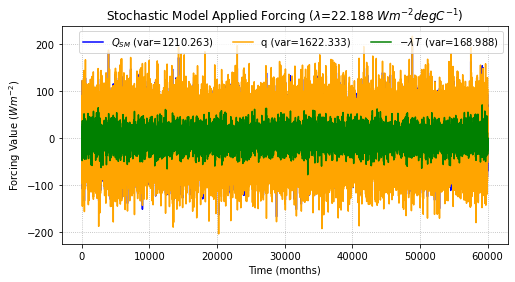

In [116]:
# Plot the stochastic model output
fig,ax = plt.subplots(1,1,figsize=(8,4))

q_ori_units = q_in*(rho*cp0*mld.mean())/dt # Convert to original units for plotting
ax.plot(Q,color='blue',label="$Q_{SM}$ (var=%.3f)"%(np.var(Q)))
ax.plot(q_ori_units,color='orange',label="q (var=%.3f)"%(np.var(q_ori_units)))
ax.plot(lbd_t,color='green',label="$-\lambda\,T$ (var=%.3f)"%(np.var(lbd_t)))
ax.legend(ncol=3)
ax.set_xlabel("Time (months)")
ax.set_ylabel("Forcing Value ($Wm^{-2}$)")
ax.set_title("Stochastic Model Applied Forcing ($\lambda$=%.3f $Wm^{-2}{degC}^{-1}$)"%(lbd_in[t] * (rho*cp0*mld.mean())))
ax.grid(True,ls='dotted')
figname = "%sStochastic_Model_Applied_Forcing.png" % (outpath)
plt.savefig(figname,dpi=200)


([<matplotlib.lines.Line2D at 0x7f5511142a10>], Text(0.5, 1.0, 'Output SST'))

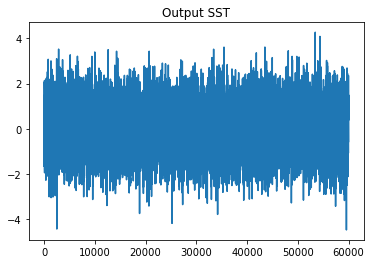

In [117]:
# Plot the temperature output (To check the magnitude is reasonable)
plt.plot(T),plt.title("Output SST")#*lbd_in * (rho*cp0*mld.mean()))

0.9239275207743533
5256.513257172674
1622.3327881822706


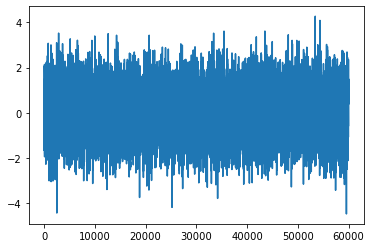

In [118]:
# Prepare for spectra calculation

# Convert back by multiplying by rho cp0 h
stochspec0 = [T,dampterm,forceterm] # Prepare to convert input from degC to W/m2
stochspec  = [] # Converted variables in W/m2 go here
i = 0
for varss in stochspec0: 
    vin = varss.copy()
    if i != 0:
        vin *= (rho*cp0*mld.mean()/dt)
    stochspec.append(vin)
    print(np.var(vin))
    i+= 1

#stochspec[0] /= (rho*cp0*mld.mean()) * dt 
# Add in the total heat flux calculated from the equation (already W/m2), as well as the damping
stochspec.append(lbd_t)
stochspec.append(Q) 
plt.plot(stochspec[0])

In [119]:
#Print Variance of each variable
stochvarn = ("SST","exp(-lambda)*T","q","-\lambda*T","Q(t)")

for v in range(len(stochvarn)):
    print("Variance(%s) is %f" % (stochvarn[v],np.var(stochspec[v])))

Variance(SST) is 0.923928
Variance(exp(-lambda)*T) is 5256.513257
Variance(q) is 1622.332788
Variance(-\lambda*T) is 168.987753
Variance(Q(t)) is 1210.263203


In [120]:
# Calculate the spectra of each one
nsm     = 1000
nsmooth = np.ones(5)*nsm
pct     = 0.1

# Calculate the spectra
stspecs,stfreqs,stCCs,stdofs,str1s = scm.quick_spectrum(stochspec,nsmooth,pct)

# Calculate associated uncertainty
alpha = 0.05
stbnds  = []
for nu in stdofs:
    lower,upper = tbx.confid(alpha,nu*2)
    stbnds.append([lower,upper])
    
# Saveoutput
savename = "%sspectra_runid%s_useeof%i_ampq%i_nsmooth%i_qvary%i_lbdvary%i.npz" % (scrappath,runid,useeof,ampq,nsm,qvary,lbdvary)
np.savez(savename,**{
    "stspecs":stspecs,
    "stfreqs":stfreqs,
    "stCCs":stCCs,
    "stdofs":stdofs,
    "stdbns":stbnds,
},allow_pickle=True)

print(savename)


Warning, window does not sum to 1!
Warning, window does not sum to 1!
Warning, window does not sum to 1!
Warning, window does not sum to 1!
Warning, window does not sum to 1!
/stormtrack/data3/glliu/01_Data/02_AMV_Project/02_stochmod/Scrap/spectra_runidth009_useeof1_ampq0_nsmooth1000_qvary1_lbdvary1.npz


In [121]:
# yumiya

# Investigate difference between theoretical spectra and CESM-SLAB $F_{QQ}$

In [122]:
# Spectral Estimation Parameters
nsm     = 500
nsmooth = [500,500,nsm,nsm,500]
pct     = 0.1

invars1 = [Ta,Qa,q_ori_units,q_mon,Qafull] # Variables to estimate power spectra from

# Calculate the spectra
specs,freqs,CCs,dofs,r1s = scm.quick_spectrum(invars1,nsmooth,pct)

Warning, window does not sum to 1!
Warning, window does not sum to 1!
Warning, window does not sum to 1!
Warning, window does not sum to 1!
Warning, window does not sum to 1!


In [123]:
# Calculate the Confidence Intervals
alpha = 0.05
bnds = []
for nu in dofs:
    lower,upper = tbx.confid(alpha,nu*2)
    bnds.append([lower,upper])
dofs

[948.7161972418921,
 948.7161972418921,
 948.7161972418921,
 948.7161972418921,
 948.7161972418921]

In [124]:
# Print the variance of each timeseries
cesmvarn = ["T'","Q'","$q_{const}'$","$q_{vary}''$","Q (CESM-FULL)"]
cesmvars = [Ta,Qa,q_avg,q_mon,Qafull]
for v in range(len(cesmvars)):
    print("Variance(%s) is %f" % (cesmvarn[v],np.var(cesmvars[v])))

Variance(T') is 0.929725
Variance(Q') is 1531.833374
Variance($q_{const}'$) is 1251.243462
Variance($q_{vary}''$) is 1622.332900
Variance(Q (CESM-FULL)) is 1553.868164


## Calculate theoretical spectra based on the older formula:


## $ F_{QQ}(\omega) = F_{qq}(\omega) \frac{\omega^2}{\omega^2+\lambda^2}$

In [125]:
# Calculate Theoretical

# Value of F_qq at zero
Fqq0  = specs[2][0]
omega = freqs[2] # Pull out frequencies


# Theoretical F_QQ, smooth estimate, assuming white noise
Qth      = Fqq0 * (omega**2 / (omega**2+(lbd_avg/2/np.pi)**2))

# F_QQ estimated with constant mean forcing amplitude
Qth_avg  = specs[2] * (omega**2 / (omega**2+(lbd_avg/2/np.pi)**2))

# F_QQ estimated with monthly varying forcing amplitude
Qth_mon  = specs[3] * (omega**2 / (omega**2+(lbd_avg/2/np.pi)**2))

## Calculate theoretical spectra based on the new formula:

## $F_{QQ}(\omega) = F_{q'q'}(\omega) + \lambda^2 \frac{F_{q'q'}(\omega)}{1+a^2-2acos(2\pi\omega)} - \lambda \frac{2(1-acos(2\pi\omega))}{1+a^2-2acos(2\pi\omega)} F_{qq}(\omega) $

Where...

## $F_{qq} = FAC^2 F_{q'q'}$

In [126]:
# Calculate the theoretical
if lbdvary:
    lbd_in2      = lbd_mon.mean()
    lbd_in2_conv = 1/(lbd_in2*3600*24*30)
else:
    lbd_in2      = (lbd_all[klon,klat,:]/(rho*cp0*mld)).mean() # Take the mean damping (1/sec)
    lbd_in2_conv = (1/(lbd_in2*3600*24*30))    # Convert to 1/mon, take mean
    
    
a                = 1 - 1/lbd_in2_conv                 # Calculate a


autocalc=True # Recalculate the theoretical spectra, assuming F_zz = FAC^2 * F_z'z'
# Function to calculate the new F_zz ratio, taken from heat_flux_theoretical_verify.py
def calc_FQQ_new(a,omega,FZZ=None,ZeqZp=False,autocalc=False):
    lbd = 1-a
    FAC = (1-np.exp(-lbd))/lbd
    
    cos_term = np.cos(2*np.pi*omega)
    denom    = 1 + a**2 - 2*a*cos_term
    
    if ZeqZp: # Assume F_ZZ = 0.90 * F_Z'Z'
        numer = 2*a**2 * (1-cos_term)
    else: # Assume F_ZZ = 0.8 F_Z'Z'
        numer = 0.2 - 0.2 * a * (1+cos_term) + a**2 * (2 - 1.8*cos_term)
    
    if autocalc:  # Calculate F_ZZ = FAC**2 F_Z'Z'
        denoms = (1+a**2-2*a*cos_term)
        term2 = lbd**2/denoms
        term3 = 2*lbd*FAC**2*(1-a*cos_term)/denoms
        
        ratios = 1 + term2 - term3
        return ratios
    
    if FZZ is None: # Just return the constant
        return numer/denom
    else: # Otherwise, multiply constant across all frequencies
        print("Returning the product")
        return FZZ * numer/denom

if qvary:
    F_ZZ = stspecs[2].copy()
    omega = freqs[3]*3600*24*30 # Convert to 1/mon
else:
    F_ZZ = stspecs[2].copy()
    omega = freqs[2]*3600*24*30

F_ZZ_theor = calc_FQQ_new(a,omega,FZZ=F_ZZ,autocalc=True)
ratios     = calc_FQQ_new(a,omega,autocalc=True)                         

scp glliu@stormtrack:/stormtrack/data3/glliu/02_Figures/20210715/NHFLX_Spectra_Theoretical_nsmooth500_taper010_lon-30_lat50_linlin_qvary1_lbdvary1.png .


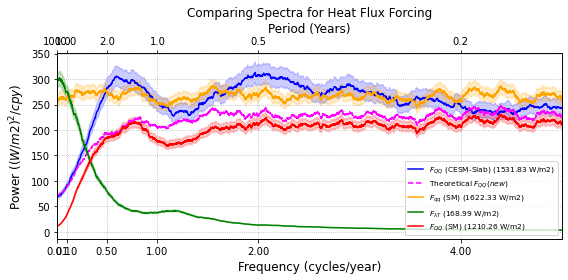

In [127]:
# Remake the Linlin, Plot, but now with the stochastic model terms

# Do a lin-lin plot

# Plot the spectra (from analysis/plot_spectra_Generals.py)

# Plotting Params
plotdt = 3600*24*365
xtick  = [1/100,1/10,1/2,1,2,4]
#ylm    = [-.01,.5]
xlm    = [5e-3,5]
titles = ("Varying Damping and Forcing (Levels 1-3)",
          "Varying Mixed-Layer Depth (Levels 3-5)")
plotconf=True

# Plotting params (SPECIFIC TO THIS SCRIPT)
nplot=len(freqs)
ecolors  = ["gray","blue","orange","cyan","purple"]
enames   = ["T","$F_{QQ}$ (CESM-Slab)","$F_{qq}$ (SM, Const)","$F_{qq}$ (Applied, Vary)","$F_{QQ}$ (CESM-Full)"]

stcolors = ["purple","cyan","orange","green","red"]
stnames  = ["$F_{QQ}$ (SM,Vary)","$F_{damping}$ (SM)","$F_{qq}$ (SM)",r"$F_{\lambda T}$","$F_{QQ}$ (SM)"]

fig,ax = plt.subplots(1,1,figsize=(8,4))
  
for n in [1]:
    ln_lab = "%s (%.2f W/m2)" % (enames[n],np.var(cesmvars[n]))
    ax.plot(freqs[n]*plotdt,specs[n]/plotdt,color=ecolors[n],label=ln_lab)

    if plotconf:
        lower,upper = bnds[n]
        cobj = ax.fill_between(freqs[n]*plotdt,lower*specs[n]/plotdt,
                                       upper*specs[n]/plotdt,
                                       alpha=0.20,color=ecolors[n],
                                       label="")

#ax.plot(omega*plotdt,Qth_mon/plotdt,color="magenta",ls='dotted',label="Theoretical $F_{QQ}$ (old)")
ax.plot(freqs[2]*plotdt,F_ZZ*ratios/plotdt,color="magenta",ls='dashed',label="Theoretical $F_{QQ} (new)$")

for n in [2,3,4]:
    ln_lab = "%s (%.2f W/m2)" % (stnames[n],np.var(stochspec[n])) 
    ax.plot(stfreqs[n]*plotdt,stspecs[n]/plotdt,color=stcolors[n],label=ln_lab)
    
    if plotconf:
        lower,upper = stbnds[n]
        cobj = ax.fill_between(stfreqs[n]*plotdt,lower*stspecs[n]/plotdt,
                                       upper*stspecs[n]/plotdt,
                                       alpha=0.20,color=stcolors[n],
                                       label="")
    

#khalf = np.argmax(Qth_mon/specs[3]>0.5)
#ax.axvline(freqs[3][khalf]*plotdt,color='k',ls='dashed')

# Set Labels
ax.set_ylabel("Power ($(W/m2)^{2} / cpy$)",fontsize=12)
ax.set_xlabel("Frequency (cycles/year)",fontsize=12)
htax = viz.twin_freqaxis(ax,freqs[1],"Years",plotdt,mode='lin-lin',xtick=xtick)

# Set upper x-axis ticks
xtick2 = htax.get_xticks()
xtkl   = ["%.1f" % (1/x) for x in xtick2]
htax.set_xticklabels(xtkl)
    
# Set axis limits
ax.set_xlim(xlm)
htax.set_xlim(xlm)  
ax.legend(fontsize=7.5,ncol=1)
    
locstring = "30W, 50N"
ax.set_title("Comparing Spectra for Heat Flux Forcing")
ax.grid(True,which='both',ls='dotted')
plt.tight_layout()

savename = "%sNHFLX_Spectra_Theoretical_nsmooth%i_taper%03i_lon-30_lat50_linlin_qvary%i_lbdvary%i.png"%(outpath,nsmooth[1],pct*100,qvary,lbdvary)
plt.savefig(savename,dpi=200)

print("scp glliu@stormtrack:%s ."%(savename))

/stormtrack/data3/glliu/02_Figures/20210715/NHFLX_Spectra_Theoretical_CESM-PIC_nsmooth500_lon-30_lat50_Ann_linlin_stochcompare_new_2panel.png


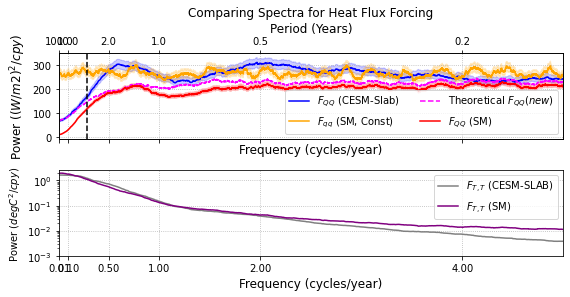

In [128]:
# Remake the Linlin, Plot, but now with the stochastic model terms

# Do a lin-lin plot

# Plot the spectra (from analysis/plot_spectra_Generals.py)

# Plotting Params
plotdt = 3600*24*365
xtick  = [1/100,1/10,1/2,1,2,4]
#ylm    = [-.01,.5]
xlm    = [5e-3,5]
titles = ("Varying Damping and Forcing (Levels 1-3)",
          "Varying Mixed-Layer Depth (Levels 3-5)")
plotconf=True

# Plotting params (SPECIFIC TO THIS SCRIPT)
nplot=len(freqs)
ecolors  = ["gray","blue","orange","cyan","purple"]
enames   = ["T","$F_{QQ}$ (CESM-Slab)","$F_{qq}$ (SM, Const)","$F_{qq}$ (Applied, Vary)","$F_{QQ}$ (CESM-Full)"]

stcolors = ["purple","orange","cyan","green","red"]
stnames  = ["$F_{QQ}$ (SM,Vary)","$F_{damping}$ (SM)","$F_{qq}$ (SM)","F_{\lambdaT(t)}","$F_{QQ}$ (SM)"]

fig,axs = plt.subplots(2,1,figsize=(8,4),sharex=True)
  
ax = axs[0]
for n in [1,2]:
    ax.plot(freqs[n]*plotdt,specs[n]/plotdt,color=ecolors[n],label=enames[n])

    if plotconf:
        lower,upper = bnds[n]
        cobj = ax.fill_between(freqs[n]*plotdt,lower*specs[n]/plotdt,
                                       upper*specs[n]/plotdt,
                                       alpha=0.20,color=ecolors[n],
                                       label="")
ax.plot(freqs[2]*plotdt,F_ZZ*ratios/plotdt,color="magenta",ls='dashed',label="Theoretical $F_{QQ} (new)$")

for n in [4]:
    ax.plot(stfreqs[n]*plotdt,stspecs[n]/plotdt,color=stcolors[n],label=stnames[n])
    
    if plotconf:
        lower,upper = stbnds[n]
        cobj = ax.fill_between(stfreqs[n]*plotdt,lower*stspecs[n]/plotdt,
                                       upper*stspecs[n]/plotdt,
                                       alpha=0.20,color=stcolors[n],
                                       label="")
    

khalf = np.argmax(Qth_mon/specs[3]>0.5)
ax.axvline(freqs[3][khalf]*plotdt,color='k',ls='dashed')

# Set Labels
ax.set_ylabel("Power ($(W/m2)^{2} / cpy$)",fontsize=12)
ax.set_xlabel("Frequency (cycles/year)",fontsize=12)
htax = viz.twin_freqaxis(ax,freqs[1],"Years",plotdt,mode='lin-lin',xtick=xtick)

# Set upper x-axis ticks
xtick2 = htax.get_xticks()
xtkl   = ["%.1f" % (1/x) for x in xtick2]
htax.set_xticklabels(xtkl)
    
# Set axis limits
ax.set_xlim(xlm)
htax.set_xlim(xlm)  
ax.legend(fontsize=10,ncol=2)
    
locstring = "30W, 50N"
ax.set_title("Comparing Spectra for Heat Flux Forcing")
ax.grid(True,which='both',ls='dotted')
plt.tight_layout()



ax = axs[1]

# Plot cesm SST
for n in [0]:
    ax.semilogy(freqs[n]*plotdt,specs[n]/plotdt,color=ecolors[n],label="$F_{T,T}$ (CESM-SLAB)")

#     if plotconf:
#         lower,upper = bnds[n]
#         cobj = ax.fill_between(freqs[n]*plotdt,lower*specs[n]/plotdt,
#                                        upper*specs[n]/plotdt,
#                                        alpha=0.20,color=ecolors[n],
#                                        label="")
# Plot stochastic model SST
#ax = ax.twinx()
#convfactor = (rho*cp0*mld.mean())

for n in [0]:
    ax.semilogy(stfreqs[n]*plotdt,stspecs[n]/plotdt,color=stcolors[n],label="$F_{T,T}$ (SM)")
    
#     if plotconf:
#         lower,upper = stbnds[n]
#         cobj = ax.fill_between(stfreqs[n]*plotdt,lower*stspecs[n]/plotdt,
#                                        upper*stspecs[n]/plotdt,
#                                        alpha=0.20,color=stcolors[n],
#                                        label="")
ax.legend()
ax.set_ylim([0.001,2.5])
ax.set_ylabel("Power ($degC^{2}/cpy$)")
ax.grid(True,ls='dotted')
ax.set_xlabel("Frequency (cycles/year)",fontsize=12)

plt.savefig("%sNHFLX_Spectra_Theoretical_CESM-PIC_nsmooth%i_lon-30_lat50_Ann_linlin_stochcompare_new_2panel.png"%(outpath,nsmooth[1]),dpi=200)
print("%sNHFLX_Spectra_Theoretical_CESM-PIC_nsmooth%i_lon-30_lat50_Ann_linlin_stochcompare_new_2panel.png"%(outpath,nsmooth[1]))

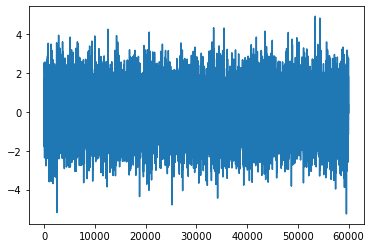

In [42]:
plt.plot(stochspec[0])

In [358]:
Tmon = T.reshape(int(T.shape[0]/12),12)
Tscycle = Tmon.mean(0)

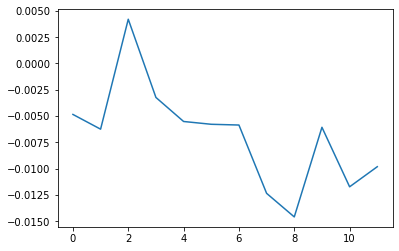

In [362]:
Tscycle = Tmon.mean(0)

plt.plot(Tscycle)

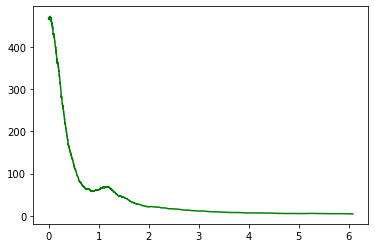

In [346]:
n = 3
plt.plot(stfreqs[n]*plotdt,stspecs[n]/plotdt,color=stcolors[n],label=stnames[n])

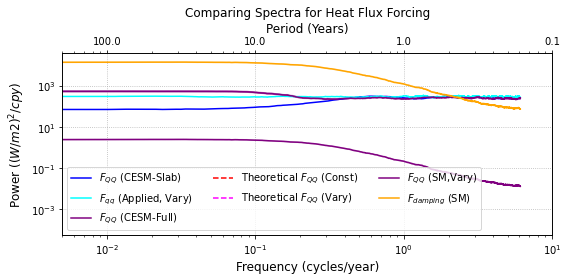

In [31]:
# Try Log log

# Do a log-log plot

# Plot the spectra (from analysis/plot_spectra_Generals.py)

# Plotting Params
plotdt = 3600*24*365
xtick  = [float(10)**(x) for x in np.arange(-4,2)]
#ylm    = [-.01,.5]
xlm    = [5e-3,10]
titles = ("Varying Damping and Forcing (Levels 1-3)",
          "Varying Mixed-Layer Depth (Levels 3-5)")
plotconf=True

# Plotting params (SPECIFIC TO THIS SCRIPT)
nplot=len(freqs)
#ecolors = ["gray","blue","orange","cyan"]
#enames = ["T","$F_{QQ}$ (CESM-Slab)","$F_{qq}$ (Applied, Const)","$F_{qq}$ (Applied, Vary)"]

fig,ax = plt.subplots(1,1,figsize=(8,4))
  
for n in [1,3,4]:
    ax.loglog(freqs[n]*plotdt,specs[n]/plotdt,color=ecolors[n],label=enames[n])

if plotconf:

    lower,upper = bnds[n]
    cobj = ax.fill_between(freqs[n]*plotdt,lower*specs[n]/plotdt,
                                   upper*specs[n]/plotdt,
                                   alpha=0.5,color=ecolors[n],
                                   label="")
    #ax.loglog(freqs[n]*plotdt,CCs[n][:,1]/plotdt,color=ecolors[n],alpha=0.5,ls='dashed')
    #ax.loglog(freqs[n]*plotdt,CCs[n][:,0]/plotdt,color=ecolors[n],alpha=0.5,ls='dotted')
    
ax.loglog(omega*plotdt,Qth_avg/plotdt,color="r",ls='dashed',label="Theoretical $F_{QQ}$ (Const)")
ax.loglog(omega*plotdt,Qth_mon/plotdt,color="magenta",ls='dashed',label="Theoretical $F_{QQ}$ (Vary)")



for n in [0,1]:
    ax.plot(stfreqs[n]*plotdt,stspecs[n]/plotdt,color=stcolors[n],label=stnames[n])
    
    if plotconf:
        lower,upper = stbnds[n]
        cobj = ax.fill_between(stfreqs[n]*plotdt,lower*stspecs[n]/plotdt,
                                       upper*stspecs[n]/plotdt,
                                       alpha=0.20,color=stcolors[n],
                                       label="")


# Set Labels
ax.set_ylabel("Power ($(W/m2)^{2} / cpy$)",fontsize=12)
ax.set_xlabel("Frequency (cycles/year)",fontsize=12)
htax = viz.twin_freqaxis(ax,freqs[1],"Years",plotdt,mode='log-log',xtick=xtick)

# Set upper x-axis ticks
xtick2 = htax.get_xticks()
xtkl = ["%.1f" % (1/x) for x in xtick2]
htax.set_xticklabels(xtkl)
    
# Set axis limits
ax.set_xlim(xlm)
htax.set_xlim(xlm)
# ax.set_ylim(ylm)
# htax.set_ylim(ylm)
    
ax.legend(fontsize=10,ncol=3)
#ax.set_title(titles[i])
    
locstring= "30W, 50N"
ax.set_title("Comparing Spectra for Heat Flux Forcing")
#ax.grid(True,which='both',ls='dotted')
plt.tight_layout()

plt.savefig("%sNHFLX_Spectra_Theoretical_CESM-PIC_nsmooth%i_lon-30_lat50_Ann_loglog_stochcompare.png"%(outpath,nsmooth[1]),dpi=200)


0.8883462553547512

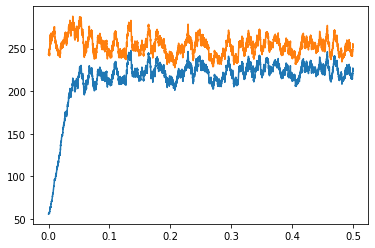

In [37]:
fig,ax = plt.subplots(1,1)
ax.plot(omega,F_ZZ*ratios/plotdt)
ax.plot(omega,F_ZZ/plotdt)

np.max(ratios)

## Compare Effect of varying lambda and q
Uses the above script, run for cases where qvary and lbdvary are turned on and off

In [296]:

searchpath = "/stormtrack/data3/glliu/01_Data/02_AMV_Project/02_stochmod/Scrap/spectra_varyexp/qvary_009_ampq/"
flist = glob.glob(searchpath+"*.npz")
print(flist)

['/stormtrack/data3/glliu/01_Data/02_AMV_Project/02_stochmod/Scrap/spectra_varyexp/qvary_009_ampq/spectra_runidth009_useeof0_ampq1_nsmooth1000_qvary0_lbdvary0.npz', '/stormtrack/data3/glliu/01_Data/02_AMV_Project/02_stochmod/Scrap/spectra_varyexp/qvary_009_ampq/spectra_runidth009_useeof0_ampq1_nsmooth1000_qvary0_lbdvary1.npz', '/stormtrack/data3/glliu/01_Data/02_AMV_Project/02_stochmod/Scrap/spectra_varyexp/qvary_009_ampq/spectra_runidth009_useeof0_ampq1_nsmooth1000_qvary1_lbdvary0.npz', '/stormtrack/data3/glliu/01_Data/02_AMV_Project/02_stochmod/Scrap/spectra_varyexp/qvary_009_ampq/spectra_runidth009_useeof0_ampq1_nsmooth1000_qvary1_lbdvary1.npz']


In [297]:
%%time
enames2  = ["All Const","Vary $\lambda$","Vary q","All Vary"]
ecolors2 = ["purple","cyan","gold","red"]


especs = []
efreqs = []
ebnds  = []
for f in range(len(flist)):

    ld = np.load(flist[f],allow_pickle=True)
    print(ld.files)
    especs.append(ld['stspecs'])
    efreqs.append(ld['stfreqs'])
    ebnds.append(ld['stdbns'])
    

['stspecs', 'stfreqs', 'stCCs', 'stdofs', 'stdbns', 'allow_pickle']
['stspecs', 'stfreqs', 'stCCs', 'stdofs', 'stdbns', 'allow_pickle']
['stspecs', 'stfreqs', 'stCCs', 'stdofs', 'stdbns', 'allow_pickle']
['stspecs', 'stfreqs', 'stCCs', 'stdofs', 'stdbns', 'allow_pickle']
CPU times: user 50.5 ms, sys: 5.87 ms, total: 56.4 ms
Wall time: 53.9 ms


In [298]:
e = 0
plotnum = 4

efreqs[e][plotnum].shape,especs[e][plotnum].shape,ebnds[e].shape

((30000,), (30000,), (5, 2))

scp glliu@stormtrack:/stormtrack/data3/glliu/02_Figures/20210715/NHFLX_Spectra_Theoretical_nsmooth1000_taper010_comparison_lowerhierarchy.png .


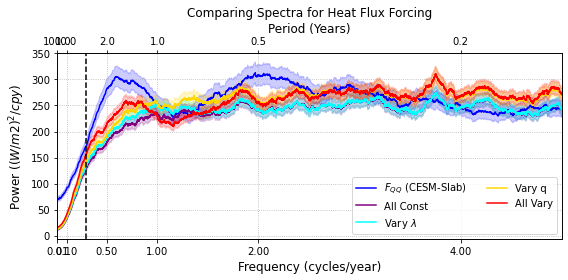

In [299]:
# Plot spectra together, linear-linear

plotnum = 4

# Plot the spectra (from analysis/plot_spectra_Generals.py)

# Plotting Params
plotdt = 3600*24*365
xtick  = [1/100,1/10,1/2,1,2,4]
#ylm    = [-.01,.5]
xlm    = [5e-3,5]
titles = ("Varying Damping and Forcing (Levels 1-3)",
          "Varying Mixed-Layer Depth (Levels 3-5)")
plotconf=True

# Plotting params (SPECIFIC TO THIS SCRIPT)
nplot=len(freqs)
ecolors  = ["gray","blue","orange","cyan","purple"]
enames   = ["T","$F_{QQ}$ (CESM-Slab)","$F_{qq}$ (SM, Const)","$F_{qq}$ (Applied, Vary)","$F_{QQ}$ (CESM-Full)"]

stcolors = ["purple","orange","cyan","green","red"]
stnames  = ["$F_{QQ}$ (SM,Vary)","$F_{damping}$ (SM)","$F_{qq}$ (SM)","F_{\lambdaT(t)}","$F_{QQ}$ (SM)"]

fig,ax = plt.subplots(1,1,figsize=(8,4))
  
for n in [1]:
    ax.plot(freqs[n]*plotdt,specs[n]/plotdt,color=ecolors[n],label=enames[n])

    if plotconf:
        lower,upper = bnds[n]
        cobj = ax.fill_between(freqs[n]*plotdt,lower*specs[n]/plotdt,
                                       upper*specs[n]/plotdt,
                                       alpha=0.20,color=ecolors[n],
                                       label="")


for e in [0,1,2,3]:#range(len(flist)):
    
    ax.plot(efreqs[e][plotnum]*plotdt,especs[e][plotnum]/plotdt,color=ecolors2[e],label=enames2[e])
        
#ax.plot(omega*plotdt,Qth_mon/plotdt,color="magenta",ls='dotted',label="Theoretical $F_{QQ}$ (old)")
#ax.plot(freqs[2]*plotdt,F_ZZ*ratios/plotdt,color="magenta",ls='dashed',label="Theoretical $F_{QQ} (new)$")

# for n in [4]:
#     ax.plot(stfreqs[n]*plotdt,stspecs[n]/plotdt,color=stcolors[n],label=stnames[n])
    
    if plotconf:
        lower,upper = ebnds[e][plotnum]
        cobj = ax.fill_between(efreqs[e][plotnum]*plotdt,lower*especs[e][plotnum]/plotdt,
                                       upper*especs[e][plotnum]/plotdt,
                                       alpha=0.20,color=ecolors2[e],
                                       label="")
    

khalf = np.argmax(Qth_mon/specs[3]>0.5)
ax.axvline(freqs[3][khalf]*plotdt,color='k',ls='dashed')

# Set Labels
ax.set_ylabel("Power ($(W/m2)^{2} / cpy$)",fontsize=12)
ax.set_xlabel("Frequency (cycles/year)",fontsize=12)
htax = viz.twin_freqaxis(ax,freqs[1],"Years",plotdt,mode='lin-lin',xtick=xtick)

# Set upper x-axis ticks
xtick2 = htax.get_xticks()
xtkl   = ["%.1f" % (1/x) for x in xtick2]
htax.set_xticklabels(xtkl)
    
# Set axis limits
ax.set_xlim(xlm)
htax.set_xlim(xlm)  
ax.legend(fontsize=10,ncol=2)
    
locstring = "30W, 50N"
ax.set_title("Comparing Spectra for Heat Flux Forcing")
ax.grid(True,which='both',ls='dotted')
plt.tight_layout()

savename = "%sNHFLX_Spectra_Theoretical_nsmooth%i_taper%03i_comparison_lowerhierarchy.png"%(outpath,nsmooth[1],pct*100)
plt.savefig(savename,dpi=200)

print("scp glliu@stormtrack:%s ."%(savename))

## Test sensitivity to different white noise timeseries

Just for the theoretical spectra for now


In [ ]:
qvary

In [ ]:

nrealizations = 100

#q_mon   = randts * np.tile(alpha,int(simlen/12)) # Monthly variying ampltiude
#q_avg   = randts * alpha.mean()      

# Create Forcings
q_all   = []
for n in tqdm.tqdm(range(nrealizations)):
    
    randts = np.random.normal(0,1,simlen)
    if qvary: #W/m2
        q_in = randts * np.tile(alpha,int(simlen/12)) 
    else:
        q_in = randts * alpha.mean()
    
    
    # Conver to 1/mon
    q_in =  q_in/(rho*cp0*mld.mean())*dt
    
    if ampq:  
        if lbdvary is False:
            q_in *= (1/underest)
        else:
            q_in *= np.tile(1/underest,int(simlen/12))
    # Convert back 
    q_in *=  (rho*cp0*mld.mean())/dt 
    
    
    
    q_all.append(q_in)
    
    
    
    
# #%%
#     if qvary:
#     q_in     = q_mon/(rho*cp0*mld.mean())*dt # Note: Slab model, MLD is constant in all cases
# else:
#     q_in     = q_avg/(rho*cp0*mld.mean())*dt

# if ampq:
    
#     if lbdvary is False:
#         print("Lbd is not varying")
#         q_in *= (1/underest)
#     else:
#         q_in *= np.tile(1/underest,int(simlen/12))
        
# # Preallocate
# T         = np.zeros(t_end) # SST               : T(t)
# Q         = np.zeros(t_end) # Net heat flux     : Q(t)
# dampterm  = T.copy()        # Damping Term      : np.exp(-lambda*dt)*T(t-1)
# forceterm = T.copy()        # Forcing Term      : FAC*q(t)
# lbd_t     = Q.copy()        # Damping Heat Flux : -lambda*T(t)

# # Integrate
# for t in tqdm.tqdm(range(t_end)):
    
#     # First integrate the temperature equation
#     dampterm[t]   = np.exp(-lbd_in[t]*dt) * T[t-1]
#     forceterm[t]  = FAC[t] * q_in[t]
#     T[t]          = dampterm[t] + forceterm[t]
    
#     # Now calculate the associated heat flux
#     lbd_ori_units = lbd_in[t] * (rho*cp0*mld.mean())    # convert back to W/m2 per degC
#     q_ori_units   = q_in[t] * (rho*cp0*mld.mean())/dt 


In [ ]:
# Calculate Spectrum
nsmooth= np.ones(nrealizations)*nsm
nspecs,nfreqs,_,ndofs,_ = scm.quick_spectrum(q_all,nsmooth,pct)


In [ ]:
# Calculate theoretical q

nratios     = calc_FQQ_new(a,omega,autocalc=True)  

nspecs = np.array(nspecs)

qtheoretical = nspecs * nratios[None,:]

nratios.shape,nspecs.shape

In [ ]:
# Now plot everything...

# Plot the spectra (from analysis/plot_spectra_Generals.py)

# Plotting Params
plotdt = 3600*24*365
xtick  = [1/100,1/10,1/2,1,2,4]
#ylm    = [-.01,.5]
xlm    = [5e-3,5]
plotconf=True

# Plotting params (SPECIFIC TO THIS SCRIPT)
nplot=len(freqs)
ecolors  = ["gray","blue","orange","cyan","purple"]
enames   = ["T","$F_{QQ}$ (CESM-Slab)","$F_{qq}$ (SM, Const)","$F_{qq}$ (Applied, Vary)","$F_{QQ}$ (CESM-Full)"]

stcolors = ["purple","orange","cyan","green","red"]
stnames  = ["$F_{QQ}$ (SM,Vary)","$F_{damping}$ (SM)","$F_{qq}$ (SM)","F_{\lambdaT(t)}","$F_{QQ}$ (SM)"]

fig,ax = plt.subplots(1,1,figsize=(8,4))
  



for n in range(nrealizations):
    ax.plot(nfreqs[n]*plotdt,nspecs[n,]/plotdt,label="",alpha=0.15)
    ax.plot(nfreqs[n]*plotdt,qtheoretical[n]/plotdt,label="",alpha=0.15)
    

    
ax.plot(nfreqs[0]*plotdt,nspecs.mean(0)/plotdt,label="mean $F_{qq}$",color="k")
ax.plot(nfreqs[0]*plotdt,qtheoretical.mean(0)/plotdt,label="mean theoretical F_{QQ}$",color="k",ls='dotted')

for n in [1]:
    ax.plot(freqs[n]*plotdt,specs[n]/plotdt,color=ecolors[n],label=enames[n])

    if plotconf:
        lower,upper = bnds[n]
        cobj = ax.fill_between(freqs[n]*plotdt,lower*specs[n]/plotdt,
                                       upper*specs[n]/plotdt,
                                       alpha=0.70,color=ecolors[n],
                                       label="")

#ax.plot(omega*plotdt,Qth_mon/plotdt,color="magenta",ls='dotted',label="Theoretical $F_{QQ}$ (old)")
#ax.plot(freqs[2]*plotdt,F_ZZ*ratios/plotdt,color="magenta",ls='dashed',label="Theoretical $F_{QQ} (new)$")

# for n in [4]:
#     ax.plot(stfreqs[n]*plotdt,stspecs[n]/plotdt,color=stcolors[n],label=stnames[n])
    
#     if plotconf:
#         lower,upper = stbnds[n]
#         cobj = ax.fill_between(stfreqs[n]*plotdt,lower*stspecs[n]/plotdt,
#                                        upper*stspecs[n]/plotdt,
#                                        alpha=0.20,color=stcolors[n],
#                                        label="")
    

khalf = np.argmax(Qth_mon/specs[3]>0.5)
ax.axvline(freqs[3][khalf]*plotdt,color='k',ls='dashed')

# Set Labels
ax.set_ylabel("Power ($(W/m2)^{2} / cpy$)",fontsize=12)
ax.set_xlabel("Frequency (cycles/year)",fontsize=12)
htax = viz.twin_freqaxis(ax,freqs[1],"Years",plotdt,mode='lin-lin',xtick=xtick)

# Set upper x-axis ticks
xtick2 = htax.get_xticks()
xtkl   = ["%.1f" % (1/x) for x in xtick2]
htax.set_xticklabels(xtkl)
    
# Set axis limits
ax.set_xlim(xlm)
htax.set_xlim(xlm)  
ax.legend(fontsize=10,ncol=2)
    
locstring = "30W, 50N"
ax.set_title("Comparing Spectra for Heat Flux Forcing")
ax.grid(True,which='both',ls='dotted')
plt.tight_layout()

savename = "%sNHFLX_Spectra_Theoretical_nsmooth%i_taper%03i_whitenoisetest.png"%(outpath,nsmooth[1],pct*100)
plt.savefig(savename,dpi=200)

print("scp glliu@stormtrack:%s ."%(savename))